| **Chapter**                   | 9:  Agent-based models                               |
| ----------------------------- |------------------------------------------------------|
| **Computational Note**        | 9.x: ABM of agents moving over a real-world network  |
| **Package prerequisites**     | [Mesa](http://mesa.readthedocs.io)                   |

# ABM of agents moving over a real-world network

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
import matplotlib
import colorcet as cc
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import pyplot as plt
import osmnx
import networkx as nx
import random
from scipy import stats
import enum

SMALL_SIZE = 5
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

random.seed(1234)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0

scipy     : 1.8.1
matplotlib: 3.5.2
numpy     : 1.21.6
colorcet  : 3.0.0
osmnx     : 1.2.0
mesa      : 0.9.0
networkx  : 2.8.4
pandas    : 1.4.2



In [3]:
road_filter = "['highway'~'motorway|motorway_link|trunk|primary|secondary|tertiary']"

In [4]:
graph = osmnx.graph_from_place("Budapest, Hungary", network_type="drive", custom_filter=road_filter)

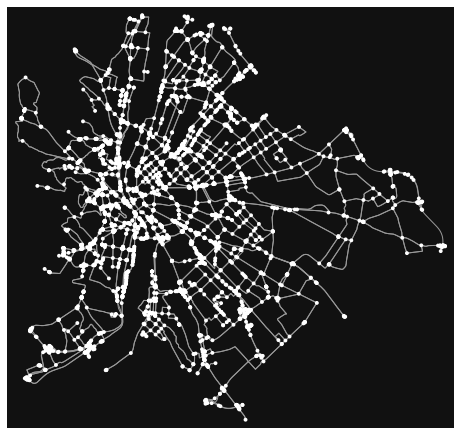

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
osmnx.plot_graph(graph)

In [6]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    DECEASED = 3

In [7]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        
    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                                                            if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if self.state is State.INFECTED and np.random.rand() < model.beta:
                neighbour.state = State.INFECTED

    def movement_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        if len(neighbourhood) > 0:
            self.pos = random.choice(neighbourhood)

    def status_update(self):        
        if self.state == State.INFECTED:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED

        if np.random.rand() < self.model.base_mortality_rate:
            self.state = State.DECEASED


    def step(self):
        self.status_update()

        if self.state is State.INFECTED:
            self.contact_event()

        if np.random.rand() > self.model.movement_probability:
            self.movement_event()
    

In [8]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 number_of_agents=4000,
                 recovery_period=7,
                 beta=0.05,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 movement_probability=0.85,
                 I0=100):
                     
        self.recovery_period = recovery_period
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate
        self.movement_probability = movement_probability

        self.graph = graph
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True
        self.epicenter = random.choice(list(graph.nodes))

        for i in range(number_of_agents - I0):
            agent = Person(uid=i + 1, model=self)
            self.schedule.add(agent)
            destination = random.choice(list(self.graph.nodes.keys()))
            self.grid.place_agent(agent, destination)

        for j in range(I0):
            agent = Person(uid=number_of_agents - I0 + j + 1, model=self)
            self.schedule.add(agent)
            destination = self.epicenter
            agent.state = State.INFECTED
            self.grid.place_agent(agent, destination)

        self.datacollector = DataCollector(agent_reporters={"State": "state", "pos": "pos"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [9]:
nodes, edges = osmnx.graph_to_gdfs(graph)

In [10]:
pop=100000

model = NetworkInfectiousDiseaseModel(pop)

node_value_set_points = [0, 6, 13, 20]
node_value_sets = []
inf_abs_numbers = []
deaths_abs_numbers = []

for i in range(max(node_value_set_points) + 1):
    model.step()

    nodes, edges = osmnx.graph_to_gdfs(model.graph)

    if i in node_value_set_points:
        nodes["infectious_pct"] = nodes.agent.apply(lambda x: sum(1 for i in x if i.state is State.INFECTED)/len(x))
        node_value_sets.append(nodes.copy())

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_5377/865580985.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


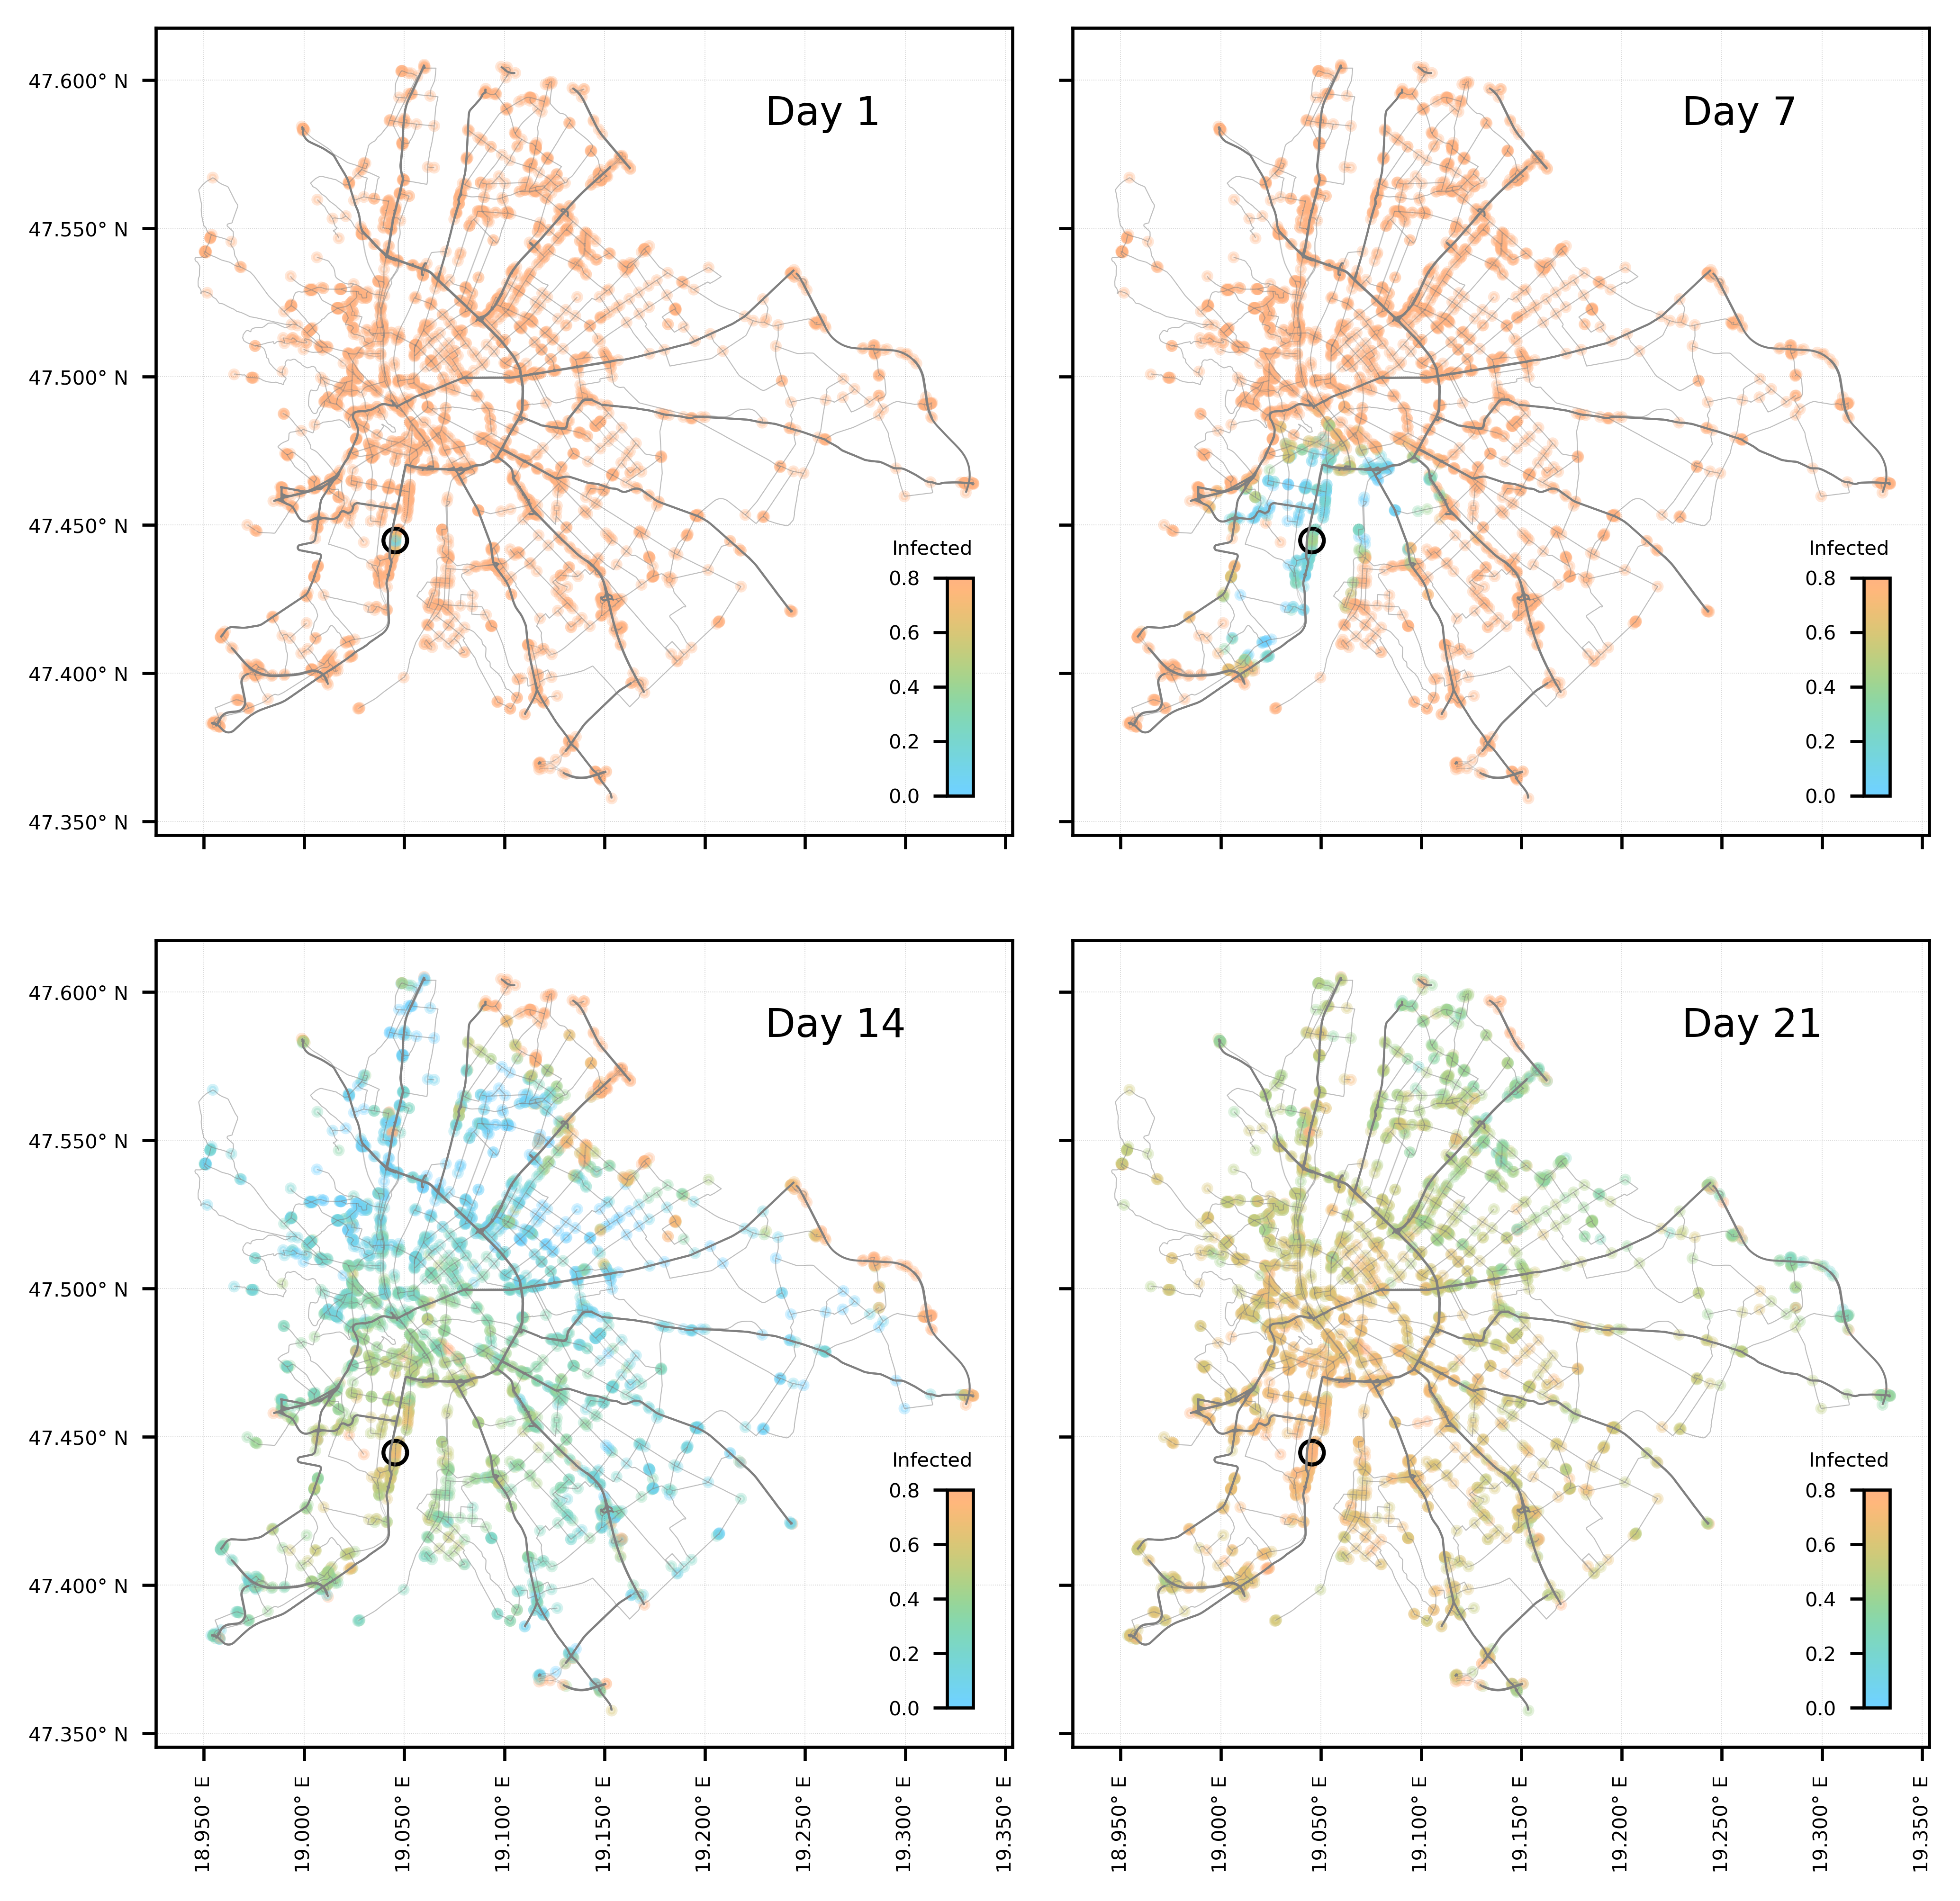

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, facecolor="w", figsize=(7, 7), dpi=600)

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
other_roads = edges.loc[~edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]

for idx, ax in enumerate(axs.flatten()):

    arterial_roads.plot(ax=ax, lw=0.5, color="gray", zorder=3)
    other_roads.plot(ax=ax, lw=0.25, color="gray", alpha=0.3, zorder=3)

    ax = node_value_sets[idx].plot("infectious_pct", ax=ax, cmap=cc.cm.isolum_r, markersize=4, legend=False, alpha=0.3, vmin=0, vmax=0.8)
    ax.text(19.23, 47.585, f"Day {node_value_set_points[idx] + 1}")


    ax.scatter(nodes.loc[model.epicenter, "x"], nodes.loc[model.epicenter, "y"], marker="o", facecolors="none", edgecolors="k")

    ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
    ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.3f}° E"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.3f}° N"))
    ax.grid()

    axins = inset_axes(ax, width="3%", height="27%", loc="lower right", borderpad=1)
    norm = colors.Normalize(0, 0.8)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cc.cm.isolum)
    ax_cbar = fig.colorbar(cbar, cax=axins)
    axins.yaxis.set_ticks_position("left")
    axins.tick_params(axis="y", labelsize=5)
    axins.set_title("Infected", loc="right")

    if idx <= 1:
        ax.xaxis.set_ticklabels([])

    if idx % 2 != 0:
        ax.yaxis.set_ticklabels([])

plt.tight_layout()

plt.savefig("network_with_movement_abm.pdf")